# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [465]:
# student details 1: Meshy B. 2864  
# student details 2: Sapir B. 3721

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT
    
Goal: Validation of assignment compliance

Propmpt1:I will share the lecturer’s detailed requirements with you. Review my code and written explanations, and determine whether each criterion has been satisfied. For any point that is not fully addressed, specify the gaps and suggest how I can improve it.

    
AI agent name 2: ChatGPT
Goal: Get help understanding the requirements and receive examples of different models

Propmpt1: What is GridSearchCV and how do I use it?

Propmpt2:Can you help me understand whether Logistic Regression and Random Forest are suitable for classifying a dataset with three classes, and what their different hyperparameters are?
    
Propmpt3: Is there a way to display model results in a clean DataFrame, with the scores shown as percentages?

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The learning task in this assignment is a binary classification problem based on the Titanic dataset
Each row in the dataset represents one passenger with information such as ticket class (Pclass), sex, age, number of siblings or spouses aboard (SibSp), parents or children (Parch), ticket fare, and port of embarkation (Embarked). 
The target variable is “Survived,” where 1 means the passenger survived and 0 means the passenger did not survive. 
The goal is to train models that can predict whether a passenger survived, and to understand which factors had the greatest impact on survival chances. The objective is to make accurate predictions and also to learn what influenced survival on the Titanic.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [471]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [472]:
# Load the data
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

# Check the shape (rows, columns) of each dataset
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape, "\n")

# Show first 5 rows of each dataset
print("Train set:")
print(train_df.head())

print("\nTest set:")
print(test_df.head())

Train shape: (712, 8)
Test shape: (179, 8) 

Train set:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0

Test set:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1




---EDA---


1. Age distribution

The histogram shows the distribution of passenger ages, as well as the distribution of those who survived and those who did not.

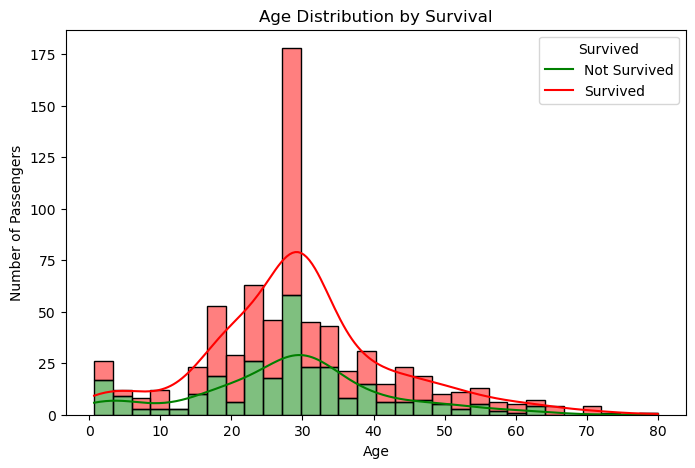

In [475]:
plt.figure(figsize=(8,5))
sns.histplot(data=train_df,x="Age",hue="Survived",bins=30,kde=True,multiple="stack",palette={0: "red", 1: "green"}) 
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend(title="Survived", labels=["Not Survived", "Survived"])
plt.show()


2. Correlation Analysis

   
Correlation analysis helps us understand the relationships between different variables in the dataset. We can see how features such as passenger class, age, and fare are related to survival, and to each other.

In [477]:
correlation = train_df[['Survived', 'Pclass', 'Age', 'Fare']].corr()
correlation.style.background_gradient(cmap='coolwarm').format(precision=2)

,Survived,Pclass,Age,Fare
Survived,1.00,-0.32,-0.07,0.26
Pclass,-0.32,1.00,-0.32,-0.54
Age,-0.07,-0.32,1.00,0.07
Fare,0.26,-0.54,0.07,1.00


3. Survival by Sex

The countplot shows survival by sex.  

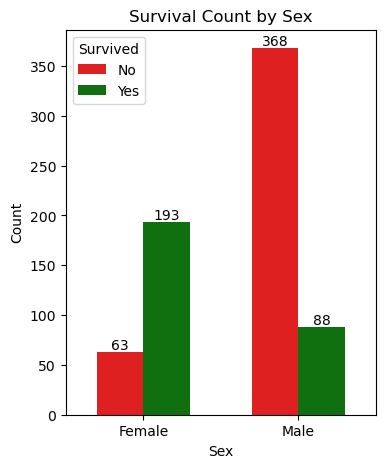

In [479]:
sex_map = {0: "Female", 1: "Male"}
train_df["Sex_label"] = train_df["Sex"].map(sex_map)

plt.figure(figsize=(4,5))
ax = sns.countplot(x="Sex_label", hue="Survived", data=train_df, width=0.6, palette={0: "red", 1: "green"})

plt.title("Survival Count by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])

for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
plt.show()


4. Survival by Pclass

The countplot shows survival by ticket class (Pclass).

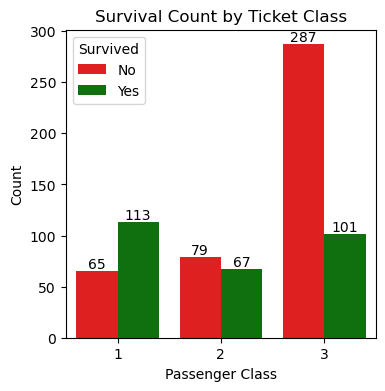

In [481]:
plt.figure(figsize=(4,4))
ax = sns.countplot(x="Pclass", hue="Survived", data=train_df, palette={0: "red", 1: "green"} )
plt.title("Survival Count by Ticket Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])

for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
        
plt.show()

In [482]:
survival_by_class = train_df.groupby("Pclass")["Survived"].mean().reset_index()

survival_by_class["Survived"] = (survival_by_class["Survived"] * 100).round(1).astype(str) + '%'

print("Survival rate by Passenger Class:")
print(survival_by_class)

Survival rate by Passenger Class:
   Pclass Survived
0       1    63.5%
1       2    45.9%
2       3    26.0%


## Part 3 - Experiments
You could add as many code cells as needed

 We tested the effect of feature engineering (scaling) on the model performance:  
1. No scaling (numeric features left as is).  
2. StandardScaler applied to numeric features.  

We evaluated both configurations using the F1-score with 5-fold cross validation.  
The comparison shows how feature scaling affects model quality.  

### Quality metric and feature engineering

We test how preprocessing affects model performance using an SVC.  
We compare two setups:
1) **No scaling** – numeric features are imputed only.  
2) **With StandardScaler** – numeric features are imputed and scaled.  

Categorical features are imputed (most frequent) and one-hot encoded.  
We use `class_weight="balanced"` to address class imbalance, and evaluate with **F1-score**
using **stratified 5-fold cross validation** for a fair comparison.


In [486]:
# ==== SVC comparison: No Scaling vs StandardScaler (simple output) ====

# 1) Define columns
num_cols = ["Age", "Fare", "SibSp", "Parch", "Pclass"]
cat_cols = ["Sex", "Embarked"]

# 2) Preprocessing pipelines
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Feature Engineering 1: No Scaling
num_pipe_no = Pipeline([("impute", SimpleImputer(strategy="median"))])
pre_no = ColumnTransformer([("num", num_pipe_no, num_cols),("cat", cat_pipe,   cat_cols)])
pipe_no = Pipeline([("pre", pre_no),("clf", SVC(class_weight="balanced"))])

# Feature Engineering 2: With StandardScaler
num_pipe_std = Pipeline([("impute", SimpleImputer(strategy="median")),("scale", StandardScaler())])
pre_std = ColumnTransformer([("num", num_pipe_std, num_cols),("cat", cat_pipe,     cat_cols)])
pipe_std = Pipeline([("pre", pre_std),("clf", SVC(class_weight="balanced"))])

# 3) Data
X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

# 4) Stratified 5-fold CV
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5) Run and print only mean F1
for name, pipe in [("No Scaling", pipe_no), ("StandardScaler", pipe_std)]:
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1", n_jobs=-1)
    print(f"{name} F1 mean:", round(scores.mean(), 4))


No Scaling F1 mean: 0.563
StandardScaler F1 mean: 0.7422


### Model 1: SVC

We use an SVC with a preprocessing pipeline.  
Numeric features: impute + scale.  
Categorical features: impute + one-hot.  
We tune `C`, `kernel`, and `gamma` with GridSearchCV.  
Evaluation: **F1-score** with **5-fold CV**.


In [488]:
# Define feature groups
num_cols = ["Age", "Fare", "SibSp", "Parch", "Pclass"]
cat_cols = ["Sex", "Embarked"]

# ----- Preprocessing -----
# Numeric pipeline: impute missing values with median + scale
num_pipe_std = Pipeline([("impute", SimpleImputer(strategy="median")),("scale", StandardScaler())])

# Categorical pipeline: impute missing values with most frequent + one-hot encoding
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Combine both pipelines
preprocessor = ColumnTransformer([("num", num_pipe_std, num_cols),("cat", cat_pipe,    cat_cols)])

# ----- Build full pipeline with SVC -----
svc_pipeline = Pipeline([
    ("pre", preprocessor),       # preprocessing step
    ("clf", SVC(class_weight="balanced"))  # classifier (handles class imbalance)
])

# ----- Define hyperparameter grid -----
param_grid_svc = {
    "clf__kernel": ["linear", "rbf"],"clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"]  # gamma relevant only for rbf
}

# ----- Cross-validation setup -----
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ----- GridSearchCV -----
grid_svc = GridSearchCV(
    estimator=svc_pipeline,param_grid=param_grid_svc,
    scoring="f1",      # evaluation metric
    cv=cv,n_jobs=-1,refit=True,return_train_score=False)

# ----- Train the model -----
grid_svc.fit(X, y)

# ----- Print results -----
print("SVC - best params:", grid_svc.best_params_)
print("SVC - best CV F1:", round(grid_svc.best_score_, 4))

# Show top 10 configurations
svc_results = pd.DataFrame(grid_svc.cv_results_)
param_cols = [c for c in svc_results.columns if c.startswith("param_")]
svc_table = svc_results[["mean_test_score", "std_test_score", "rank_test_score"] + param_cols].sort_values("mean_test_score", ascending=False)

print("\nTop configurations (sorted by mean CV F1):")
print(svc_table.head(10).round(4).to_string(index=False))

# Save best model for later use on the test set
best_svc_model = grid_svc.best_estimator_


SVC - best params: {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
SVC - best CV F1: 0.7544

Top configurations (sorted by mean CV F1):
 mean_test_score  std_test_score  rank_test_score  param_clf__C param_clf__gamma param_clf__kernel
          0.7544          0.0155                1           1.0             auto               rbf
          0.7525          0.0206                2           1.0            scale               rbf
          0.7412          0.0164                3           0.1            scale               rbf
          0.7310          0.0298                4          10.0             auto               rbf
          0.7283          0.0221                5           0.1             auto               rbf
          0.7246          0.0303                6          10.0            scale               rbf
          0.7196          0.0257                7           0.1            scale            linear
          0.7196          0.0257                7           0.

Result – SVC

The best configuration of the SVC model uses kernel = rbf, C = 1, gamma = auto,
achieving an average F1-score of about 0.75 with 5-fold cross validation.
This shows that proper hyperparameter tuning can improve performance compared to default settings.

### Model 2: RandomForest

We use a RandomForest classifier with a preprocessing pipeline.  
Numeric features: impute only (no scaling needed).  
Categorical features: impute + one-hot.  

We tune `n_estimators`, `max_depth`, and `min_samples_split` with GridSearchCV.  
Evaluation: **F1-score** with **5-fold CV**.


In [491]:
# Numeric pipeline: impute missing values with median
num_pipe_no = Pipeline([("impute", SimpleImputer(strategy="median"))])

# Categorical pipeline: impute + one-hot encoding
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Combine numeric and categorical pipelines
preprocessor_rf = ColumnTransformer([("num", num_pipe_no, num_cols),("cat", cat_pipe,    cat_cols)])

# Full pipeline: preprocessing -> RandomForest
rf_pipeline = Pipeline([("pre", preprocessor_rf),("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))])

# Hyperparameter grid for RandomForest
param_grid_rf = {"clf__n_estimators": [200, 400],"clf__max_depth": [None, 5, 10],"clf__min_samples_split": [2, 5]}

# Cross-validation setup (same as Model 1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with 5-fold CV and F1-score
grid_rf = GridSearchCV(estimator=rf_pipeline,param_grid=param_grid_rf,scoring="f1",cv=cv,n_jobs=-1,refit=True,return_train_score=False)

# Train
grid_rf.fit(X, y)

# Best result
print("RandomForest - best params:", grid_rf.best_params_)
print("RandomForest - best CV F1:", round(grid_rf.best_score_, 4))

# Results table (top 10)
rf_results = pd.DataFrame(grid_rf.cv_results_)
param_cols = [c for c in rf_results.columns if c.startswith("param_")]
rf_table = rf_results[["mean_test_score", "std_test_score", "rank_test_score"] + param_cols].sort_values("mean_test_score", ascending=False)

print("\nTop configurations (sorted by mean CV F1):")
print(rf_table.head(10).round(4).to_string(index=False))

# Save best model for later use on the test set
best_rf_model = grid_rf.best_estimator_


RandomForest - best params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
RandomForest - best CV F1: 0.757

Top configurations (sorted by mean CV F1):
 mean_test_score  std_test_score  rank_test_score param_clf__max_depth  param_clf__min_samples_split  param_clf__n_estimators
          0.7570          0.0276                1                   10                             5                      400
          0.7552          0.0225                2                   10                             5                      200
          0.7469          0.0228                3                   10                             2                      400
          0.7468          0.0218                4                 None                             5                      200
          0.7462          0.0237                5                 None                             5                      400
          0.7460          0.0256                6            

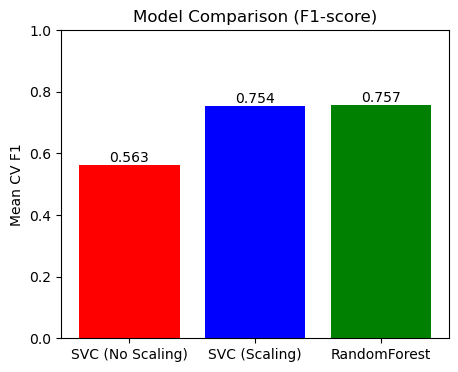

In [492]:
no_scaling_score = cross_val_score(pipe_no, X, y, cv=cv, scoring="f1").mean()
svc_best_score = grid_svc.best_score_
rf_best_score = grid_rf.best_score_

scores = {
    "SVC (No Scaling)": no_scaling_score,
    "SVC (Scaling)": svc_best_score,
    "RandomForest": rf_best_score}

plt.figure(figsize=(5,4))
bars = plt.bar(scores.keys(), scores.values(), color=["red","blue","green"])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.3f}", 
             ha="center", va="bottom")

plt.ylim(0,1)
plt.ylabel("Mean CV F1")
plt.title("Model Comparison (F1-score)")
plt.show()


**Result (RandomForest):**  
Best configuration gives mean F1 ≈ 0.757 
(with parameters `n_estimators=400, max_depth=10, min_samples_split=2`).  
This shows how tuning tree-based


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [495]:
# Preprocessing pipeline: impute missing numeric values + one-hot encode categorical features
preprocessor_best = ColumnTransformer([("num", Pipeline([("impute", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)])


In [496]:
# Full pipeline: preprocessing + RandomForest with best hyperparameters
best_model_pipeline = Pipeline([("pre", preprocessor_best),
    ("clf", RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_split=2, class_weight="balanced", random_state=42))])


In [497]:
# Train the model on the entire training dataset
best_model_pipeline.fit(X, y)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=400, random_state=42))])

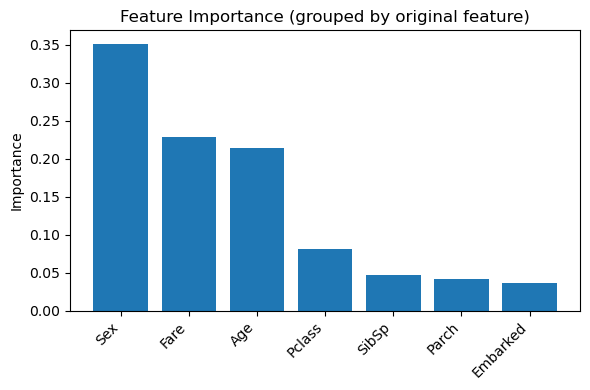

In [498]:
# Extract feature names after preprocessing
ohe = best_model_pipeline.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(ohe_features)

# Extract feature importances
importances = best_model_pipeline.named_steps["clf"].feature_importances_

# Map one-hot features back to original
mapped_features = []
for f in all_features:
    if f.startswith("Embarked"):
        mapped_features.append("Embarked")
    elif f.startswith("Sex"):
        mapped_features.append("Sex")
    else:
        mapped_features.append(f)

# Sum importances by original feature
importance_df = pd.DataFrame({"feature": mapped_features, "importance": importances})
importance_grouped = importance_df.groupby("feature", as_index=False).sum().sort_values("importance", ascending=False)

# Plot 
plt.figure(figsize=(6,4))
plt.bar(importance_grouped["feature"], importance_grouped["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Feature Importance (grouped by original feature)")
plt.tight_layout()
plt.show()


The graph shows which features are most important for predicting survival.
Sex is the most important feature, meaning gender strongly affects survival.
Fare (ticket price) and Age are also very important.


## Part 5 - Apply on test and show model performance estimation

In this step, we apply the trained model on the test set. If the column Survived exists,   
it will be used as the true labels (y_test) for evaluation.    
Otherwise, the model only produces predictions. Below we show the first five predictions.

In [502]:
# Predict on test set using the trained pipeline
X_test = test_df.copy()
if "Survived" in X_test.columns:  
    y_test = X_test.pop("Survived")
else:
    y_test = None

y_pred = best_model_pipeline.predict(X_test)
# Display first 5 predictions (0 or 1)
print("First 5 predictions on test set:", y_pred[:5])


First 5 predictions on test set: [0 0 0 1 1]


### Model evaluation on the test set

In this step, we evaluate the trained model on the **test set**.  
We compute the following metrics:  

- **Accuracy**: overall percentage of correct predictions.  
- **F1-score**: balanced measure of precision and recall, especially important for imbalanced classes.  
- **Classification Report**: detailed breakdown of precision, recall, and F1-score for each class (0 = Did not survive, 1 = Survived).  
- **Confusion Matrix**: shown both as raw counts and as normalized values, to visualize the distribution of correct and incorrect predictions.  


***
In the following results 
0 = Did not survive, 1 = Survived 
***

Test Accuracy: 88.3%
Test F1-score: 82.1%

Classification Report:
              precision    recall  f1-score   support

           0      0.894     0.932     0.913       118
           1      0.857     0.787     0.821        61

    accuracy                          0.883       179
   macro avg      0.876     0.860     0.867       179
weighted avg      0.882     0.883     0.881       179



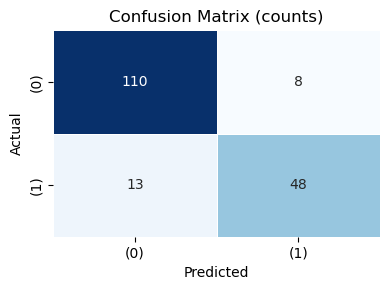

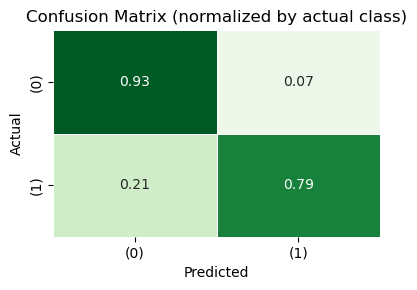

In [504]:
print("***\nIn the following results \n0 = Did not survive, 1 = Survived \n***\n")

if y_test is not None:
    # --- Metrics ---
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc*100:.1f}%")

    f1 = f1_score(y_test, y_pred)
    print(f"Test F1-score: {f1*100:.1f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # --- Confusion Matrix (heatmap) ---
    labels = ["(0)", "(1)"]

    # Counts
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=labels, yticklabels=labels,cbar=False, linewidths=.5, linecolor="white")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (counts)")
    plt.tight_layout()
    plt.show()

    # Normalized
    cm_norm = confusion_matrix(y_test, y_pred, labels=[0,1], normalize="true")
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",xticklabels=labels, yticklabels=labels,cbar=False, linewidths=.5, linecolor="white",
                vmin=0, vmax=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (normalized by actual class)")
    plt.tight_layout()
    plt.show()
